##### Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00025: Introduction to Vibration Theory


### Class 15 - Vibration of plates

[1.   The plate equation](#section_1)  
[2.   Static solution by approximation](#section_2)  
[3.   Potential and kinetic energies](#section_3)  
[4.   Vibration modes and frequencies](#section_4)  
[5.   Assignment](#section_5)  

---
_Prof. Marcelo M. Rocha, Dr.techn._ [(ORCID)](https://orcid.org/0000-0001-5640-1020)  
_Porto Alegre, RS, Brazil_ 


In [2]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)
import numpy as np
import matplotlib.pyplot as plt

# Modules required for surface plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


## 1. The plate equation <a name="section_1"></a> 


<img src="images/Timoshenko_plate.png" alt="Timoshenko plate" width="320px"/>


We will use as an example a $8\times5$ meters simply supported thin reinforced 
concrete plate, with thicknes $t = 0.1$m. 
The elasticity modulus for concrete is assumed to be $E = 30$GPa and the 
Poisson's ratio is $\nu = 0.3$. 
The material average density (specific mass) is assumed to be $2500 {\rm kg/m^3}$.


In [33]:
# Material data

E  = 30.e9         # elasticity modulus (N/m2)
nu = 0.2           # Poisson's ratio (non-dim)
ro = 2500.         # density (specific mass, kg/m^3)
t  = 0.1           # plate thickness (m)
a  = 8.0           # dimension in x direction (m)
b  = 5.0           # dimension in y direction (m)

D  = E*t**3/12/(1 - nu**2)   # plate constant (Nm)
mu = ro*t                    # mass per unit area (kg/m^2)

# Domain discretization

nx = int(40*a)     # number of discretization points in x
ny = int(40*b)     # number of discretization points in y

sx = 1 + int(a)    # plot stride in x direction
sy = 1 + int(b)    # plot stride in y direction

x    = np.linspace(0, a, nx)          # x axis discretization
y    = np.linspace(0, b, ny)          # y axis discretization
X, Y = np.meshgrid(x, y, copy=False)  # xy mesh definition (save memory)


Now we propose a tentative solution that respect the kinematic boundary conditions both in 
terms of displacements and rotations. For the simply suported plate, we assume that
a product of two half sine functions may be used:


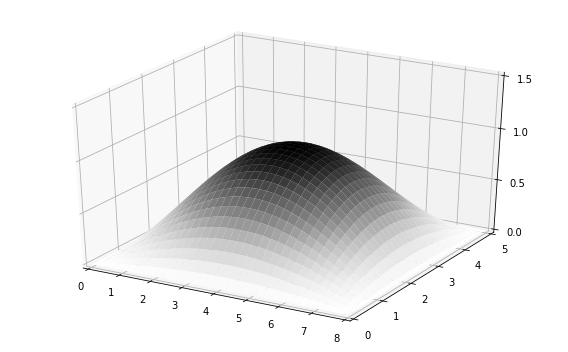

In [34]:
# Hypothetical solution

W0   = np.sin(np.pi*X/a) * np.sin(np.pi*Y/b)

# Visualization

f1   = plt.figure(1, figsize=(8,5))
ax   = f1.gca(projection='3d')

ax.plot_surface(X, Y, W0, 
                rstride=sy, cstride=sx, 
                cmap=cm.Greys, shade=True);

ax.set_xticks(np.linspace(0,   a, sx));  ax.set_xlim((0,   a));
ax.set_yticks(np.linspace(0,   b, sy));  ax.set_ylim((0,   b));
ax.set_zticks(np.linspace(0, 1.5,  4));  ax.set_zlim((0, 1.5));
    
f1.tight_layout()
plt.show()


The function proposed above has a unity amplitude, what leaves the actual amplitude to be
still evaluated according to the type of analysis (imposed load or free vibration).


## 2. Static solution by approximation <a name="section_2"></a> 

Most of the approximate solutions requires the calculation of second order derivatives
of function $w(x,y)$. 

To provide a general differentiation scheme, in the following scripts
we use ```numpy``` resources to fit, evaluate, and differentiate a 2D polynomial of 
fourth order:

$$ w(x,y) = \sum_i \sum_j \, C_{ij} \, x^i \, y^j $$

The data that must be provided to the least squares fitting algorithim can be the
discretized tentative function, but also any bunch of coordinates that resembles
the expected deformed shape. You can even _draw_ this deformed shape and measure
the coordinates from your drawing (!!!).
The important issue is satisfying the kinematic boundary conditions 
(displacements and rotations).

Below is a demonstration how to fit such polynomial to the proposed solution:


In [4]:
# Fitting a fourth order 2-D polynomial to w(x,y)

X = X.flatten()
Y = Y.flatten()
B = W0.flatten()

#             Ci0    Ci1     Ci2        Ci3        Ci4
A = np.array([X*0+1, Y,      Y**2,      Y**3,      Y**4,
              X,     X*Y,    X*Y**2,    X*Y**3,    X*Y**4,
              X**2,  X**2*Y, X**2*Y**2, X**2*Y**3, X**2*Y**4,
              X**3,  X**3*Y, X**3*Y**2, X**3*Y**3, X**3*Y**4,
              X**4,  X**4*Y, X**4*Y**2, X**4*Y**3, X**4*Y**4]).T


Cij, resid, rank, singv = np.linalg.lstsq(A, B, rcond=None)
Cij = Cij.reshape(5,5)

np.set_printoptions(precision=2)
print(Cij)


[[ 1.52e-06  7.74e-04  2.67e-05 -7.26e-05  7.26e-06]
 [ 4.70e-04  2.38e-01  8.22e-03 -2.24e-02  2.24e-03]
 [ 1.02e-05  5.16e-03  1.78e-04 -4.84e-04  4.84e-05]
 [-1.72e-05 -8.74e-03 -3.01e-04  8.20e-04 -8.20e-05]
 [ 1.08e-06  5.46e-04  1.88e-05 -5.12e-05  5.12e-06]]


The fitted polynomial is evaluated and plotted below to demonstrate the 
quality of the fitting procedure:


Root mean square error across the plate: 0.038%


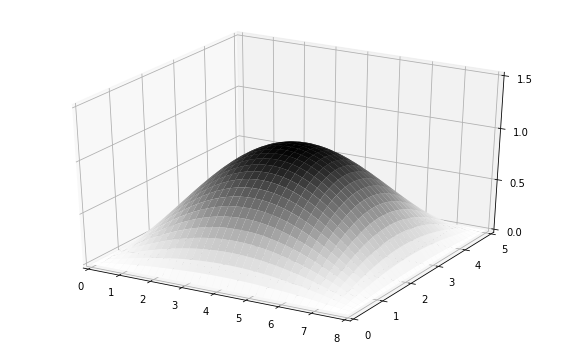

In [36]:
# Reconstituting the approximated function

X  = X.reshape(ny,nx)
Y  = Y.reshape(ny,nx)
W1 = np.polynomial.polynomial.polyval2d(X, Y, Cij)

err = np.sqrt(np.sum((W0 - W1)**2)/nx/ny)

print('Root mean square error across the plate: {0:5.3f}%'.format(100*err))

# Visualization

f2 = plt.figure(2, figsize=(8,5))
ax = f2.gca(projection='3d')

ax.plot_surface(X, Y, W1, 
                rstride=sy, cstride=sx, 
                cmap=cm.Greys, shade=True)

ax.set_xticks(np.linspace(0,   a, sx));  ax.set_xlim((0,   a));
ax.set_yticks(np.linspace(0,   b, sy));  ax.set_ylim((0,   b));
ax.set_zticks(np.linspace(0, 1.5,  4));  ax.set_zlim((0, 1.5));
    
f2.tight_layout()
plt.show()


## 3. Potential and kinetic energies <a name="section_3"></a> 

The potential elastic energy per unit area of a thin plate is given by:

$$ dV = \frac{1}{2}D \left\{ 
        \left( \frac{\partial^2 w}{\partial x^2} + \frac{\partial^2 y}{\partial y^2} \right)^2
        - 2(1 - \nu) \left[
        \frac{\partial^2 w}{\partial x^2} \frac{\partial^2 y}{\partial y^2}
        - \left( \frac{\partial^2 w}{\partial x \partial y} \right)^2
        \right] \right\} \, dx \, dy $$

which must be integrated over the plate total area to give the total elastic energy $V$.

The polynomial approximation allow us to calculate the partial derivatives without the
need of a numerical differentiation scheme. 
The function below implements the derivative for a 2D polynomial:


In [37]:
# Derivatives of the 2D polynomial: defining a function

def polyder2D(C, kx=0, ky=0):

    derC   = C.copy()
    nx, ny = C.shape
    
    for ix in range(kx):
        for ii in range(nx-1):
            derC[ii,:]   = (ii+1)*derC[ii+1,:]
            derC[ii+1,:] =  0.

    for iy in range(ky):
        for jj in range(ny-1):
            derC[:,jj]   = (jj+1)*derC[:,jj+1]
            derC[:,jj+1] =  0.
    
    return derC
    
# Testing

Cij_11 = polyder2D(Cij, 1, 1)
print(Cij_11)


[[ 2.38e-01  1.64e-02 -6.71e-02  8.94e-03  0.00e+00]
 [ 1.03e-02  7.11e-04 -2.90e-03  3.87e-04  0.00e+00]
 [-2.62e-02 -1.81e-03  7.38e-03 -9.83e-04  0.00e+00]
 [ 2.18e-03  1.51e-04 -6.15e-04  8.20e-05  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]]


Observe that the proposed function keeps the polynomial order to allow some direct
algebra with the coefficients, but the non-zero matrix elements shows the 
correct order reduction.

Now we can calculate the specific energy directly from the derived polynomials:


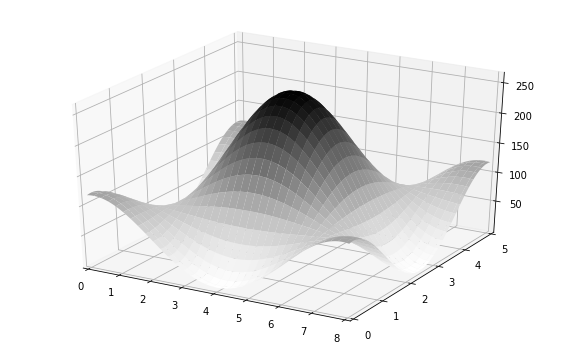

In [38]:
# Calculate specific elastic energy

Cxx =  polyder2D(Cij, 2, 0)
Cyy =  polyder2D(Cij, 0, 2)
Cxy =  polyder2D(Cij, 1, 1)

Wxx =  np.polynomial.polynomial.polyval2d(X, Y, Cxx)
Wyy =  np.polynomial.polynomial.polyval2d(X, Y, Cyy)
Wxy =  np.polynomial.polynomial.polyval2d(X, Y, Cxy)

dV  = ((Wxx + Wyy)**2 - 2*(1 - nu)*(Wxx*Wyy - Wxy**2))*D/2

# Visualize energy density

f3 = plt.figure(3, figsize=(8,5))
ax = f3.gca(projection='3d')

ax.plot_surface(X, Y, dV/1000, 
                rstride=sy, cstride=sx, 
                cmap=cm.Greys, shade=True)

ax.set_xticks(np.linspace(0,   a, sx));  ax.set_xlim((0,   a));
ax.set_yticks(np.linspace(0,   b, sy));  ax.set_ylim((0,   b));
    
f3.tight_layout()
plt.show()


The total elastic potential energy can be obtained by integrating the specific energy:

In [40]:
V = np.sum(dV)*a*b/(nx-1)/(ny-1)

print('Total elastic energy in the plate: {0:5.0f}kJ'.format(V/1000))


Total elastic energy in the plate:  3933kJ


On the other hand the reference kinetic energy per unit area depends directly 
from the solution $w(x,y)$ as:

$$ dT_{\rm ref} = \frac{1}{2} \mu w^2 \, dx \, dy$$

which can be easily evaluated and integrated with the tentative solution:


In [49]:
dTr = (W1**2)*mu/2
Tr  = np.sum(dTr)*a*b/(nx-1)/(ny-1)

print('Total kinetic in the plate: {0:5.0f}J'.format(Tr))


Total kinetic in the plate:  1250J


## 4. Vibration modes and frequencies <a name="section_4"></a> 


<img src="images/plates.png" alt="Plates modal shapes" width="640px"/>


In [52]:
f0 = np.sqrt(D/mu)*((np.pi/a)**2 +(np.pi/b)**2)/2/np.pi
f1 = np.sqrt(V/Tr)/2/np.pi

print('Exact frequency for the given thin plate:      {0:5.2f}Hz'.format(f0))
print('Estimated modal frequency for the given shape: {0:5.2f}Hz'.format(f1))


Exact frequency for the given thin plate:       8.92Hz
Estimated modal frequency for the given shape:  8.93Hz


## 5. Assignments <a name="section_5"></a> 

Propose a product of trigonometric functions to approximate the modal shape of
case 8 in table above. Compare the natural frequency obtained from polynomial 
approximation and the frequency provided by the table.
